# Based on Keras

In [1]:
# Required imports
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import plotly.offline as py
from plotly.offline import iplot
import plotly.graph_objs as go
import numpy as np
import os
import pandas as pd
path = './data'
filename_read = os.path.join(path, 'WCOILWTICO.csv')
df = pd.read_csv(filename_read)

data = df.set_index('DATE') # set_index @ https://blog.csdn.net/jingyi130705008/article/details/78162758/


Using TensorFlow backend.


In [2]:
py.init_notebook_mode(connected=True)
%matplotlib inline

In [3]:
# Plot the data read_in
cop_trace = go.Scatter(x=data.index, y=data['WCOILWTICO'], name= 'Price')
py.plot([cop_trace])

'file:///Users/marenwen/env/Oil Predict RNN/temp-plot.html'

In [4]:
# Create a scaled version of the data with oil prices normalized between 0 and 1
values = data['WCOILWTICO'].values.reshape(-1, 1) # pd.values.reshape() @ https://stackoverflow.com/questions/14390224/reshape-of-pandas-series
values = values.astype('float32') # the initial dtype is float64
scaler  =MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

scaled


array([[0.11237834],
       [0.11397506],
       [0.10317821],
       ...,
       [0.38229924],
       [0.40381688],
       [0.4103558 ]], dtype=float32)

In [5]:
# Split data between training and testing
train_size = int(len(scaled) * 0.7)
test_size = int(len(scaled) - train_size)
train, test = scaled[0:train_size], scaled[train_size:]
print(len(train), len(test))
train[0:3, 0]
#train[3, 0]



1178 505


array([0.11237834, 0.11397506, 0.10317821], dtype=float32)

In [6]:
# Generates the X and Y data from the downloaded dataset. The last n values in the input data are left off
# and the Y values are generated by shifting the X values by n 
# where n is  the value of the prev_periods paramater

# See the example below , prev_periods is set to 2
# Original X (weeks 1 - 5) = 1.05, 1.15, 1.25, 1.35, 1.45
# New X (weeks 1 - 3) = 1.05, 1.15, 1.25
# Y = 1.25, 1.35, 1.45

# Pay attention to the type of datset, is it a list, an ndarray, or a Set?
def gen_datasets(dataset, prev_periods):
    dataX, dataY = [], []
    for i in range(len(dataset) - prev_periods):
        a = dataset[i:(i  + prev_periods), 0] # dataset[train/test, axis = none], axis = 0 transferes columns vector to row vector
        dataX.append(a)
        dataY.append(dataset[i + prev_periods, 0])
    print(len(dataY))
    
    return np.array(dataX), np.array(dataY)

        

In [37]:
# Generate testing and validation data
# Use a slding window of size 1 week to predict next week oil price
prev_periods = 1
trainX, trainY = gen_datasets(train, prev_periods)
testX, testY = gen_datasets(test, prev_periods)

1177
504


In [38]:
trainX.shape[0], trainX.shape[1], trainX.shape

(1177, 1, (1177, 1))

In [ ]:
# Reshape into a numpy array of shape (m, 1, prev_periods) where m is the number of training or testing values

In [39]:
trainX =  np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Keras Based RNN Model Building

In [40]:
# Build RNN construction model based on Keras
model = Sequential()
model.add(LSTM(100, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae', 'acc'])
history = model.fit(trainX, trainY, epochs = 50, batch_size = 32, validation_data = (testX, testY), verbose = 0, shuffle = None)


In [41]:
training_error = model.evaluate(trainX, trainY, verbose = 0)
testing_error = model.evaluate(testX, testY, verbose=0)
print('Training error: %.5f MSE (%.5f RMSE) %.5f MAE' % (training_error[0], sqrt(training_error[0]), training_error[1]))
print('Testing error: %.5f MSE (%.5f RMSE) %.5f MAE' % (testing_error[0], sqrt(testing_error[0]), testing_error[1]))

Training error: 0.00019 MSE (0.01372 RMSE) 0.01104 MAE
Testing error: 0.00056 MSE (0.02368 RMSE) 0.01725 MAE


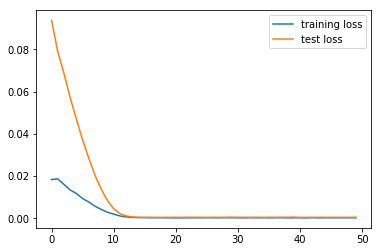

In [42]:
# Plot validation loss  vs epoch number
pyplot.plot(history.history['loss'], label='training loss')
pyplot.plot(history.history['val_loss'], label='test loss')
pyplot.legend()
pyplot.show()

(504, 1)


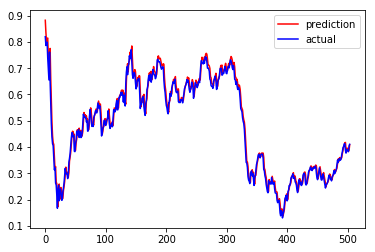

In [43]:
# Plot prediction vs actual using scaled values (0, 1)
yhat_test = model.predict(testX)
print(yhat_test.shape)
pyplot.plot(yhat_test, color='red', label='prediction')
pyplot.plot(testY, color='blue', label='actual')
pyplot.legend()
pyplot.show()

In [44]:
# Convert scaled prices back to original scale (USD)
yhat_test_inverse = scaler.inverse_transform(yhat_test.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

# Add dates back
dates = data.tail(len(testX)).index
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_test_reshape = yhat_test_inverse.reshape(len(yhat_test_inverse))

In [45]:
# Calculate MSE< RMSE based on original USD prices
mse = mean_squared_error(testY_inverse, yhat_test_inverse)
rmse = sqrt(mse)
print('Test MSE(USD): %.3f Test RMSE(USD): %.3f' % (mse, rmse))

Test MSE(USD): 9.697 Test RMSE(USD): 3.114


In [46]:
# Plot actual vs predicted using actual dates and USD
actual = go.Scatter(x=dates, y=testY_reshape, line = dict(color = ('rgb(0, 0, 255)'), width = 4), name= 'Actual Price')
predicted = go.Scatter(x=dates, y=yhat_test_reshape, line = dict(color = ('rgb(255, 0, 0)'), width = 4), name= 'Predicted Price')
py.iplot([predicted, actual])

In [47]:
# Grab last week of  normalized data and reshape into shape expected by model 
scaled_last_prices = scaled[len(scaled) - prev_periods:len(scaled),:]
scaled_last_prices = np.reshape(scaled_last_prices, (1, 1, prev_periods))

print(scaled_last_prices)

[[[0.4103558]]]


In [48]:
# Predict the price for the week of 4/6/2018 using the model
# Note this will be on a scale of (0,1)
#print(new_scaled_last_prices.shape)
next_price_prediction = model.predict(scaled_last_prices)

In [49]:
# Transform scaled predicion back to a USD price
next_price_inverse = scaler.inverse_transform(next_price_prediction.reshape(-1, 1))
print(next_price_inverse)

[[65.570366]]
